<a href="https://colab.research.google.com/github/ujjwalbb30/CMSC_678_ASL_image_classification_ML/blob/main/python_notebooks/Part_1_CNN_ReLU_ASL_Image_Classification_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifiying American Sign Language (ASL) images using Covolutional Neural Network (CNN) models**
# **Activation Function : 'ReLU'**

In this notebook, I will be training 10 different CNN models to classify ASL images. I will mainly use 'ReLU' activation function in the hidden layers. I will be conducting following experiments in this notebook:

▶ 5 different CNN models (with 1 Convolutional layer, 1 MaxPooling layer and 1 Dropout Layer) will be trained with following kernel sizes:

>(a) (4,4)

>(b) (5,5)

>(c) (6,6)

>(d) (7,7)

>(e) (8,8)

▶ For each kernel size mentioned above, 1 more type of CNN model (having the following characteristics), will be trained:

>(a) 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers

▶ In total, 10 models will be trained and following metrics will be calculated for each model along with Confusion matrix:

> (a) Accuracy

> (b) Precision

> (c) Recall

> (d) F1-score

## **Importing required libraries and data**

In [ ]:
# installing split-folders library to split the images dataset folders into training, validation and testing folders
!pip install split-folders

###**Importing required libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import random
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing tensorflow, keras and their required modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# importing sklearn and their required modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import os
import gc

import splitfolders

###**Mounting the drive and copying the data to allocated machine**

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied
drive_path = '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset' '/content'

Streaming output truncated to the last 5000 lines.
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1898.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1898.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1904.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1904.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1890.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1890.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1880.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1880.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1908.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1908.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1888.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1888.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1876.jpg' -> '/content/dataset/asl_alphabet_tr

###**Splitting the images dataset folder into train, validation and test images**
###**creating train, validation and test dataframes of image paths and labels**

In [ ]:
# splitting the folder intro training, validation and test dataset
splitfolders.ratio("/content/dataset/asl_alphabet_train", output="/content/dataset/split_dataset", seed=42, ratio=(.7, .1, .2), group_prefix=None)

Copying files: 87020 files [00:12, 6859.38 files/s]


In [ ]:
# Exploring the new created split dataset folder
dataset_folder_path = '/content/dataset/split_dataset'
for path, directories, files in os.walk(dataset_folder_path):
    print(path,'--> number of files : ', len(files))

/content/dataset/split_dataset --> number of files :  0
/content/dataset/split_dataset/test --> number of files :  0
/content/dataset/split_dataset/test/I --> number of files :  602
/content/dataset/split_dataset/test/B --> number of files :  600
/content/dataset/split_dataset/test/K --> number of files :  600
/content/dataset/split_dataset/test/M --> number of files :  600
/content/dataset/split_dataset/test/A --> number of files :  600
/content/dataset/split_dataset/test/F --> number of files :  600
/content/dataset/split_dataset/test/W --> number of files :  600
/content/dataset/split_dataset/test/Z --> number of files :  600
/content/dataset/split_dataset/test/U --> number of files :  600
/content/dataset/split_dataset/test/J --> number of files :  600
/content/dataset/split_dataset/test/nothing --> number of files :  600
/content/dataset/split_dataset/test/R --> number of files :  600
/content/dataset/split_dataset/test/L --> number of files :  600
/content/dataset/split_dataset/t

In [ ]:
# Preparing train, validation and test dataframes of image paths and labels

# defining the path to train, validation and test images data folders
train_dataset_folder = '/content/dataset/split_dataset/train'
validation_dataset_folder = '/content/dataset/split_dataset/val'
test_dataset_folder = '/content/dataset/split_dataset/test'

# initializing empty lists to store paths and labels of train, validation and test images
train_data = []
val_data = []
test_data = []

# saving train images paths and labels
for folder in os.listdir(train_dataset_folder):
    label_folder = os.path.join(train_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles

# saving validation images paths and labels
for folder in os.listdir(validation_dataset_folder):
    label_folder = os.path.join(validation_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    val_data += onlyfiles

# saving test images paths and labels
for folder in os.listdir(test_dataset_folder):
    label_folder = os.path.join(test_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    test_data += onlyfiles

# creating dataframes from the lists
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# viewing the details of training dataframe
print('training data:\n')
display(train_data_df)
print('\nunique labels:\n',train_data_df['label'].unique())
print('\n number of unique labels:\n',train_data_df['label'].nunique())

# viewing the details of validation dataframe
print('\nvalidation data:\n')
display(val_data_df)
print('\nunique labels:\n',val_data_df['label'].unique())
print('\n number of unique labels:\n',val_data_df['label'].nunique())

# viewing the details of testing dataframe
print('\ntesting data:\n')
display(test_data_df)
print('\nunique labels:\n',test_data_df['label'].unique())
print('\n number of unique labels:\n',test_data_df['label'].nunique())

training data:



,label,path
0,I,/content/dataset/split_dataset/train/I/I2242.jpg
1,I,/content/dataset/split_dataset/train/I/I1159.jpg
2,I,/content/dataset/split_dataset/train/I/I512.jpg
3,I,/content/dataset/split_dataset/train/I/I1000.jpg
4,I,/content/dataset/split_dataset/train/I/I2856.jpg
...,...,...
60909,P,/content/dataset/split_dataset/train/P/P216.jpg
60910,P,/content/dataset/split_dataset/train/P/P2255.jpg
60911,P,/content/dataset/split_dataset/train/P/P569.jpg
60912,P,/content/dataset/split_dataset/train/P/P878.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

validation data:



,label,path
0,I,/content/dataset/split_dataset/val/I/I301.jpg
1,I,/content/dataset/split_dataset/val/I/I2355.jpg
2,I,/content/dataset/split_dataset/val/I/I1761.jpg
3,I,/content/dataset/split_dataset/val/I/I2032.jpg
4,I,/content/dataset/split_dataset/val/I/I696.jpg
...,...,...
8697,P,/content/dataset/split_dataset/val/P/P2932.jpg
8698,P,/content/dataset/split_dataset/val/P/P2612.jpg
8699,P,/content/dataset/split_dataset/val/P/P1073.jpg
8700,P,/content/dataset/split_dataset/val/P/P1388.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

testing data:



,label,path
0,I,/content/dataset/split_dataset/test/I/I1856.jpg
1,I,/content/dataset/split_dataset/test/I/I525.jpg
2,I,/content/dataset/split_dataset/test/I/I636.jpg
3,I,/content/dataset/split_dataset/test/I/I1972.jpg
4,I,/content/dataset/split_dataset/test/I/I423.jpg
...,...,...
17399,P,/content/dataset/split_dataset/test/P/P1895.jpg
17400,P,/content/dataset/split_dataset/test/P/P822.jpg
17401,P,/content/dataset/split_dataset/test/P/P656.jpg
17402,P,/content/dataset/split_dataset/test/P/P42.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29


In [ ]:
# viewing random images of each label from train dataframe

unique_asl_signs = train_data_df['label'].unique().tolist()
images = []

for sign in unique_asl_signs:
    rows = train_data_df[train_data_df['label']==sign]['path']
    random_pick = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_pick]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(sign)
    plt.imshow(img)

In [ ]:
# viewing number of images in train dataset, validation dataset and test dataset
print(f'training data size: {len(train_data_df)}')
print(f'validation data size: {len(val_data_df)}')
print(f'testing data size: {len(test_data_df)}')

training data size: 60914
validation data size: 8702
testing data size: 17404


###**Creating image data generators for train, validation and test image dataset to feed the images to training models in batches**

In [ ]:
# creating image data generators

# defining image dimensions, batch size, target size of image, target dimensions and number of labels
img_dim = 64
batch_size = 64
target_size = (img_dim, img_dim)
target_dims = (img_dim, img_dim, 3)
num_classes = len(train_data_df['label'].unique())

# images are normalized, but not augmented

# train image generator
train_datagen = ImageDataGenerator(rescale = 1/255.0)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data_df,x_col='path', y_col='label', target_size=(img_dim, img_dim),class_mode='categorical', batch_size=batch_size, shuffle=False)

# validation image generator
validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)

# testing image generator
test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 60914 validated image filenames belonging to 29 classes.
Found 8702 validated image filenames belonging to 29 classes.
Found 17404 validated image filenames belonging to 29 classes.


## **CNN Models with 1 Convolutional layer, 1 Maxpooling layer and 1 Dropout layer**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_1l = Sequential()

model_1_1l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_1l.add(Activation('relu'))
model_1_1l.add(MaxPooling2D((2, 2)))
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Flatten())
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Dense(128, activation='relu'))

model_1_1l.add(Dense(num_classes, activation='softmax'))

model_1_1l.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 28800)             0         
                                                        

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 75s 78ms/step - loss: 3.4313 - accuracy: 0.0399 - val_loss: 3.3001 - val_accuracy: 0.0841
Epoch 2/10
952/952 [==============================] - 73s 77ms/step - loss: 2.6090 - accuracy: 0.2607 - val_loss: 1.7011 - val_accuracy: 0.4917
Epoch 3/10
952/952 [==============================] - 74s 77ms/step - loss: 1.4195 - accuracy: 0.5559 - val_loss: 0.9680 - val_accuracy: 0.6897
Epoch 4/10
952/952 [==============================] - 73s 77ms/step - loss: 0.9669 - accuracy: 0.6842 - val_loss: 0.6240 - val_accuracy: 0.8142
Epoch 5/10
952/952 [==============================] - 73s 77ms/step - loss: 0.6931 - accuracy: 0.7671 - val_loss: 0.4882 - val_accuracy: 0.8639
Epoch 6/10
952/952 [==============================] - 73s 77ms/step - loss: 0.5328 - accuracy: 0.8199 - val_loss: 0.3766 - val_accuracy: 0.8759
Epoch 7/10
952/952 [==============================] - 73s 77ms/step - loss: 0.4519 - accuracy: 0.8475 - val_loss: 0.2793 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.431282,0.039942,3.300149,0.084119
1,2.609037,0.260745,1.701072,0.491726
2,1.419495,0.555882,0.967985,0.689726
3,0.966903,0.684227,0.624038,0.814181
4,0.693088,0.767147,0.488227,0.863939
5,0.532789,0.819926,0.376557,0.875891
6,0.451938,0.847539,0.279267,0.908642
7,0.363228,0.874889,0.221297,0.927718
8,0.308466,0.891454,0.192665,0.935302
9,0.265679,0.908872,0.146992,0.951965


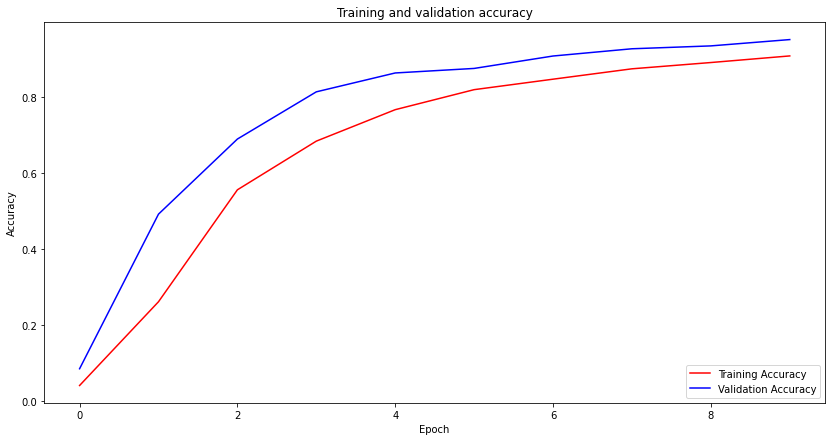

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_1l.history.history['accuracy']
val_acc= model_1_1l.history.history['val_accuracy']
loss= model_1_1l.history.history['loss']
val_loss= model_1_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

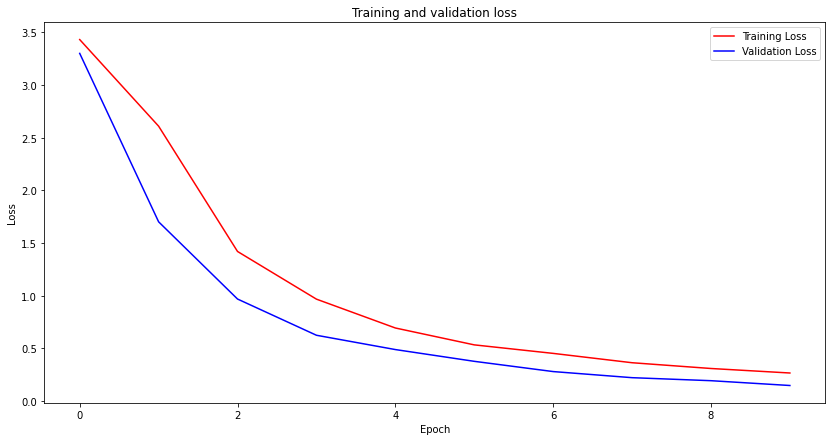

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 16s 60ms/step - loss: 0.1468 - accuracy: 0.9502
loss : 0.1467592716217041 acc : 0.9502413272857666


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 17s 61ms/step
              precision    recall  f1-score   support

           A       1.00      0.93      0.96       600
           B       0.99      0.95      0.97       600
           C       0.98      1.00      0.99       600
           D       1.00      0.98      0.99       600
           E       0.92      0.98      0.95       600
           F       1.00      1.00      1.00       600
           G       1.00      0.96      0.98       600
           H       0.96      1.00      0.98       600
           I       1.00      0.99      0.99       602
           J       1.00      1.00      1.00       600
           K       0.99      0.99      0.99       600
           L       1.00      0.99      1.00       600
           M       0.89      0.92      0.90       600
           N       1.00      0.78      0.88       602
           O       0.82      1.00      0.90       600
           P       0.88      1.00      0.93       600
           Q       0.99 

<Figure size 3600x3600 with 0 Axes>

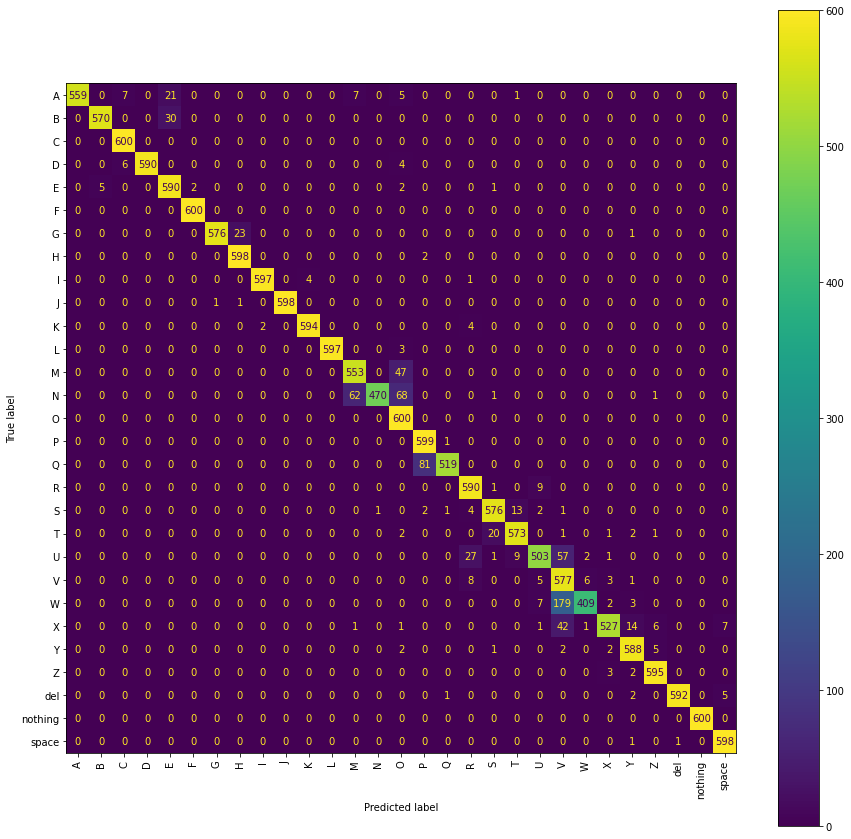

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_1l = Sequential()

model_2_1l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_1l.add(Activation('relu'))
model_2_1l.add(MaxPooling2D((2, 2)))
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Flatten())
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Dense(128, activation='relu'))

model_2_1l.add(Dense(num_classes, activation='softmax'))

model_2_1l.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_1 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_3 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 75s 78ms/step - loss: 3.3782 - accuracy: 0.0461 - val_loss: 3.4255 - val_accuracy: 0.0784
Epoch 2/10
952/952 [==============================] - 74s 78ms/step - loss: 2.6011 - accuracy: 0.2591 - val_loss: 1.8655 - val_accuracy: 0.4361
Epoch 3/10
952/952 [==============================] - 74s 78ms/step - loss: 1.6127 - accuracy: 0.5070 - val_loss: 1.0466 - val_accuracy: 0.6815
Epoch 4/10
952/952 [==============================] - 74s 78ms/step - loss: 1.1558 - accuracy: 0.6334 - val_loss: 0.7133 - val_accuracy: 0.7881
Epoch 5/10
952/952 [==============================] - 76s 79ms/step - loss: 0.9080 - accuracy: 0.7072 - val_loss: 0.5988 - val_accuracy: 0.8135
Epoch 6/10
952/952 [==============================] - 75s 78ms/step - loss: 0.7302 - accuracy: 0.7603 - val_loss: 0.5140 - val_accuracy: 0.8296
Epoch 7/10
952/952 [==============================] - 75s 78ms/step - loss: 0.6095 - accuracy: 0.7997 - val_loss: 0.3468 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.378205,0.046147,3.425532,0.078373
1,2.601137,0.259103,1.865480,0.436107
2,1.612740,0.506961,1.046648,0.681453
3,1.155844,0.633352,0.713333,0.788095
4,0.908026,0.707243,0.598850,0.813491
5,0.730159,0.760269,0.513973,0.829579
6,0.609524,0.799652,0.346820,0.893473
7,0.534098,0.824638,0.291198,0.916686
8,0.452569,0.849903,0.244191,0.917605
9,0.413049,0.862035,0.198489,0.940359


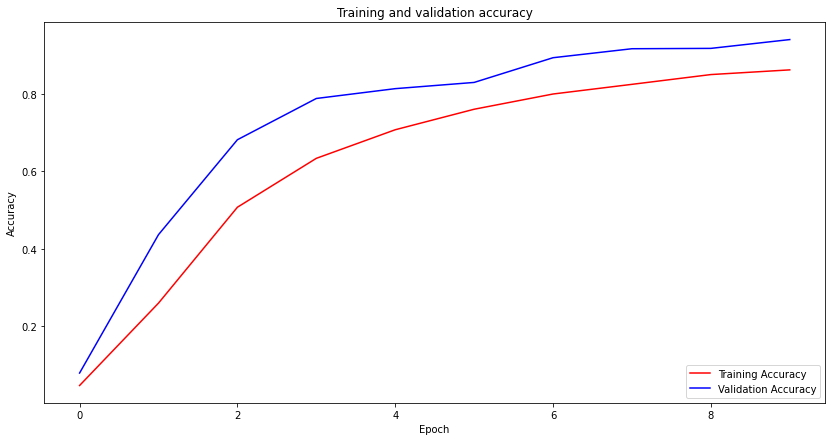

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_1l.history.history['accuracy']
val_acc= model_2_1l.history.history['val_accuracy']
loss= model_2_1l.history.history['loss']
val_loss= model_2_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

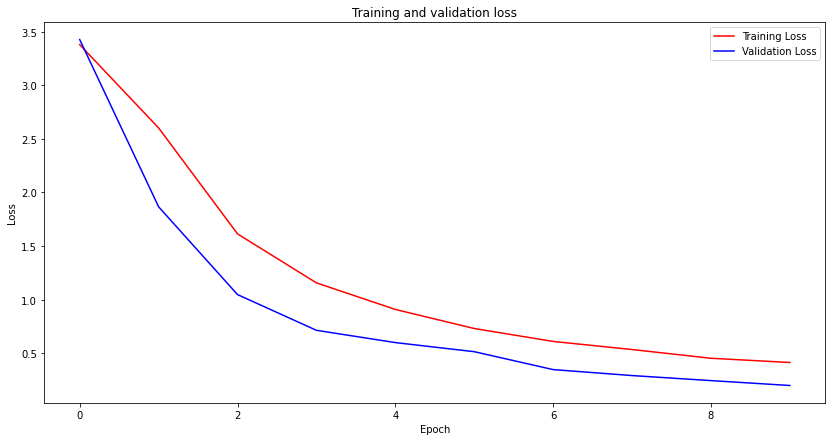

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 17s 63ms/step - loss: 0.1973 - accuracy: 0.9403
loss : 0.19725202023983002 acc : 0.9403010606765747


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 16s 60ms/step
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       600
           B       0.97      0.96      0.97       600
           C       1.00      1.00      1.00       600
           D       1.00      0.99      0.99       600
           E       0.96      0.94      0.95       600
           F       0.99      0.99      0.99       600
           G       0.99      0.98      0.98       600
           H       0.99      0.98      0.98       600
           I       0.99      0.98      0.98       602
           J       0.99      0.99      0.99       600
           K       0.96      0.96      0.96       600
           L       0.99      1.00      1.00       600
           M       0.87      0.96      0.91       600
           N       0.99      0.84      0.91       602
           O       0.97      0.94      0.95       600
           P       0.82      0.99      0.90       600
           Q       0.98 

<Figure size 3600x3600 with 0 Axes>

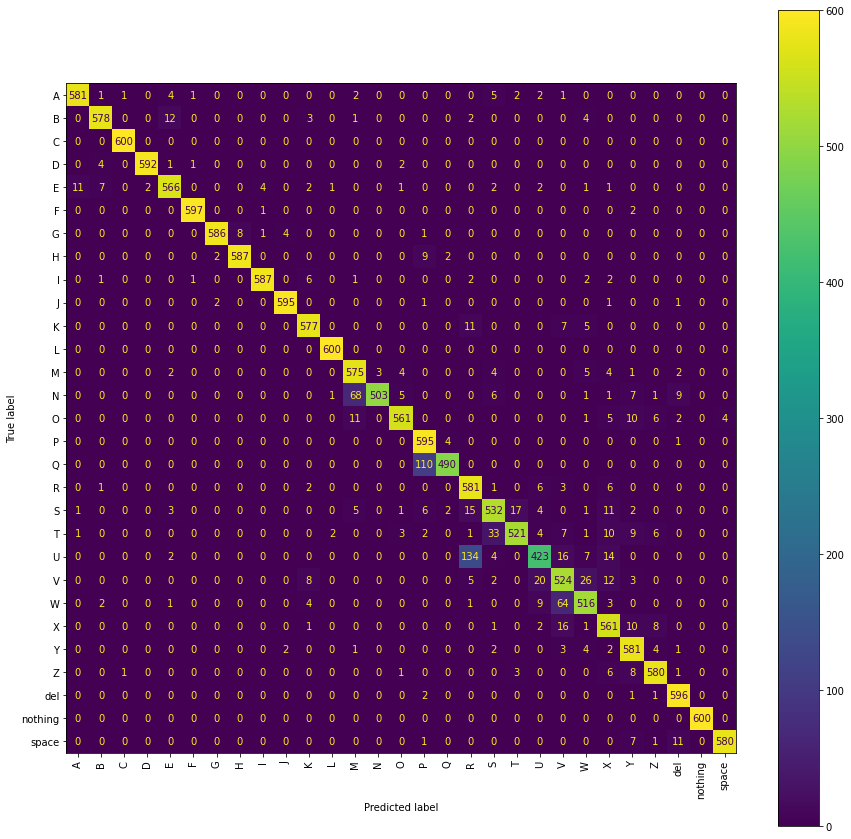

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_1l = Sequential()

model_3_1l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_1l.add(Activation('relu'))
model_3_1l.add(MaxPooling2D((2, 2)))
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Flatten())
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Dense(128, activation='relu'))

model_3_1l.add(Dense(num_classes, activation='softmax'))

model_3_1l.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_3 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_7 (Dropout)         (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 74s 77ms/step - loss: 3.2495 - accuracy: 0.1169 - val_loss: 2.3319 - val_accuracy: 0.3529
Epoch 2/10
952/952 [==============================] - 74s 78ms/step - loss: 1.7653 - accuracy: 0.4660 - val_loss: 1.2089 - val_accuracy: 0.6039
Epoch 3/10
952/952 [==============================] - 74s 77ms/step - loss: 1.0351 - accuracy: 0.6650 - val_loss: 0.6896 - val_accuracy: 0.7817
Epoch 4/10
952/952 [==============================] - 73s 77ms/step - loss: 0.7178 - accuracy: 0.7621 - val_loss: 0.4761 - val_accuracy: 0.8498
Epoch 5/10
952/952 [==============================] - 74s 78ms/step - loss: 0.5345 - accuracy: 0.8177 - val_loss: 0.3480 - val_accuracy: 0.8921
Epoch 6/10
952/952 [==============================] - 74s 78ms/step - loss: 0.4217 - accuracy: 0.8544 - val_loss: 0.2673 - val_accuracy: 0.9200
Epoch 7/10
952/952 [==============================] - 74s 78ms/step - loss: 0.3293 - accuracy: 0.8847 - val_loss: 0.2375 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.249518,0.116903,2.331945,0.352907
1,1.765349,0.466018,1.208887,0.603884
2,1.035084,0.665020,0.689627,0.781659
3,0.717759,0.762124,0.476114,0.849805
4,0.534545,0.817677,0.347991,0.892094
5,0.421655,0.854385,0.267323,0.920018
6,0.329327,0.884723,0.237504,0.924385
7,0.284069,0.901665,0.188897,0.942887
8,0.238952,0.915914,0.173303,0.944725
9,0.202187,0.928161,0.121691,0.963342


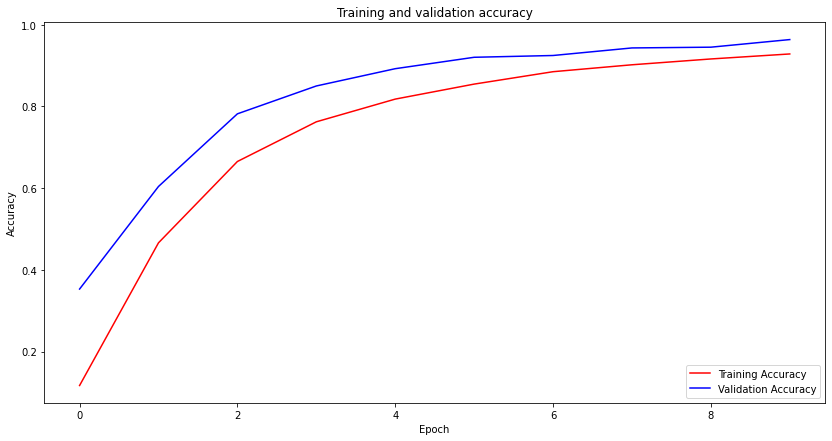

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_1l.history.history['accuracy']
val_acc= model_3_1l.history.history['val_accuracy']
loss= model_3_1l.history.history['loss']
val_loss= model_3_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

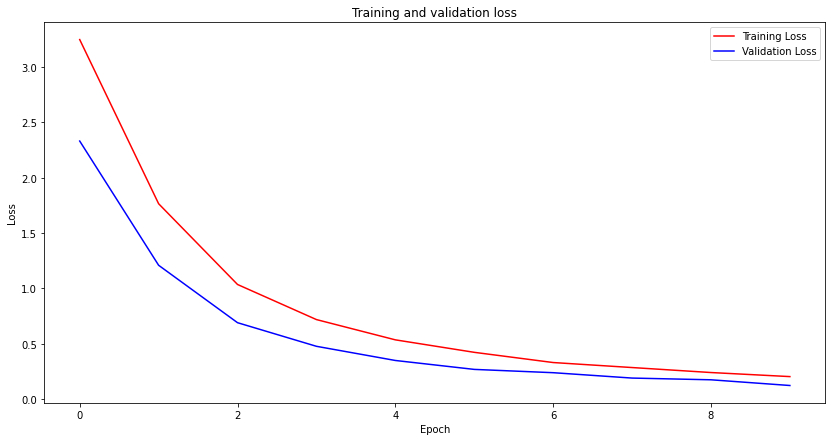

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 17s 61ms/step - loss: 0.1216 - accuracy: 0.9621
loss : 0.12164146453142166 acc : 0.9621351361274719


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 16s 60ms/step
              precision    recall  f1-score   support

           A       0.99      0.90      0.95       600
           B       0.97      0.98      0.98       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       0.88      0.98      0.93       600
           F       1.00      1.00      1.00       600
           G       0.98      0.98      0.98       600
           H       0.99      0.97      0.98       600
           I       0.99      0.99      0.99       602
           J       0.99      1.00      0.99       600
           K       0.99      0.99      0.99       600
           L       1.00      0.99      1.00       600
           M       1.00      0.81      0.89       600
           N       0.92      0.98      0.95       602
           O       0.95      0.96      0.96       600
           P       0.97      0.99      0.98       600
           Q       1.00 

<Figure size 3600x3600 with 0 Axes>

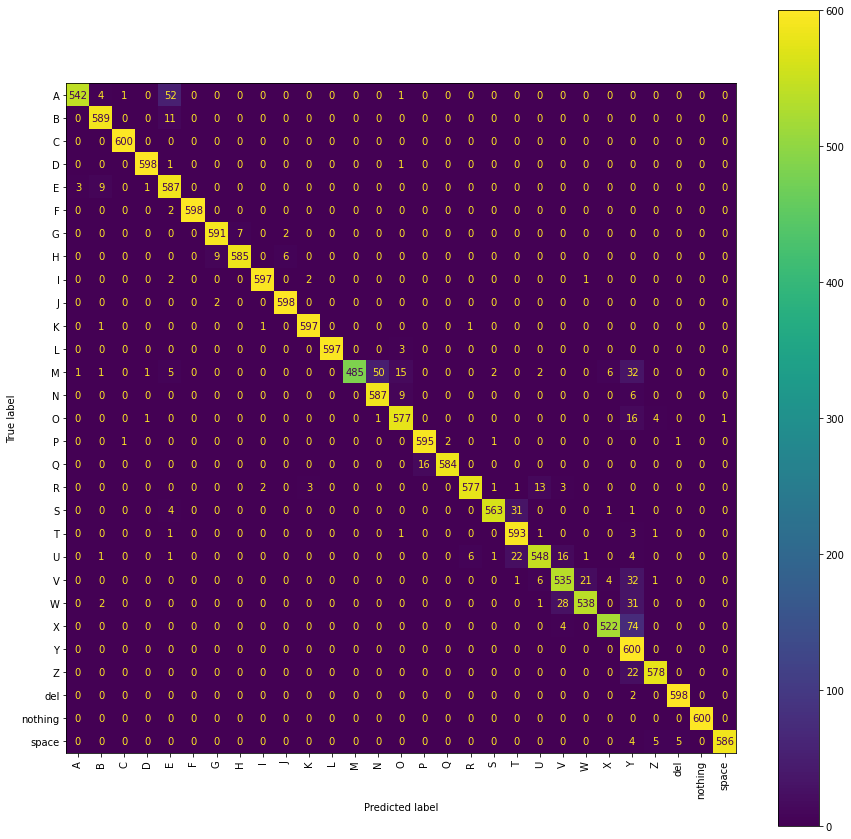

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_1l = Sequential()

model_4_1l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_1l.add(Activation('relu'))
model_4_1l.add(MaxPooling2D((2, 2)))
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Flatten())
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Dense(128, activation='relu'))

model_4_1l.add(Dense(num_classes, activation='softmax'))

model_4_1l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_4 (Activation)   (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_9 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 76s 80ms/step - loss: 3.2555 - accuracy: 0.0882 - val_loss: 2.5476 - val_accuracy: 0.2686
Epoch 2/10
952/952 [==============================] - 76s 79ms/step - loss: 2.0374 - accuracy: 0.3961 - val_loss: 1.3002 - val_accuracy: 0.6158
Epoch 3/10
952/952 [==============================] - 75s 79ms/step - loss: 1.2142 - accuracy: 0.6187 - val_loss: 0.8697 - val_accuracy: 0.7149
Epoch 4/10
952/952 [==============================] - 75s 79ms/step - loss: 0.8851 - accuracy: 0.7120 - val_loss: 0.6057 - val_accuracy: 0.8106
Epoch 5/10
952/952 [==============================] - 76s 80ms/step - loss: 0.6676 - accuracy: 0.7806 - val_loss: 0.4213 - val_accuracy: 0.8643
Epoch 6/10
952/952 [==============================] - 75s 79ms/step - loss: 0.5342 - accuracy: 0.8242 - val_loss: 0.3336 - val_accuracy: 0.8998
Epoch 7/10
952/952 [==============================] - 75s 79ms/step - loss: 0.4429 - accuracy: 0.8521 - val_loss: 0.2368 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.255500,0.088239,2.547611,0.268559
1,2.037405,0.396132,1.300238,0.615835
2,1.214237,0.618659,0.869656,0.714893
3,0.885058,0.712020,0.605710,0.810618
4,0.667590,0.780559,0.421282,0.864284
5,0.534235,0.824244,0.333627,0.899793
6,0.442900,0.852119,0.236811,0.927718
7,0.378168,0.872148,0.188800,0.947254
8,0.348125,0.882244,0.201823,0.932774
9,0.298702,0.899350,0.154046,0.953114


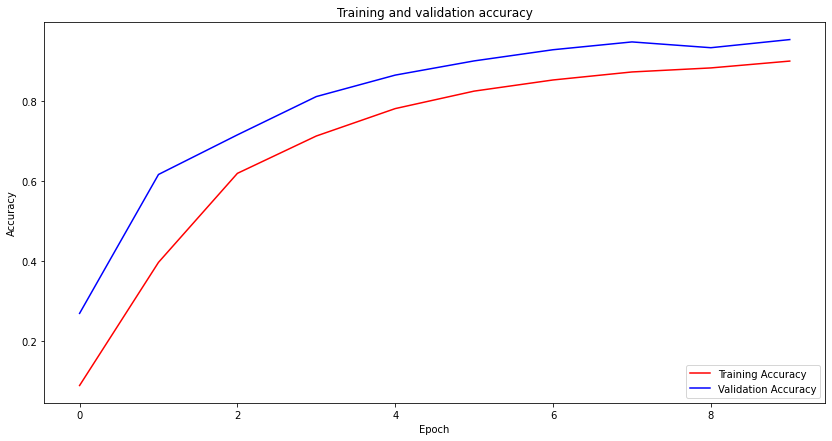

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_1l.history.history['accuracy']
val_acc= model_4_1l.history.history['val_accuracy']
loss= model_4_1l.history.history['loss']
val_loss= model_4_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

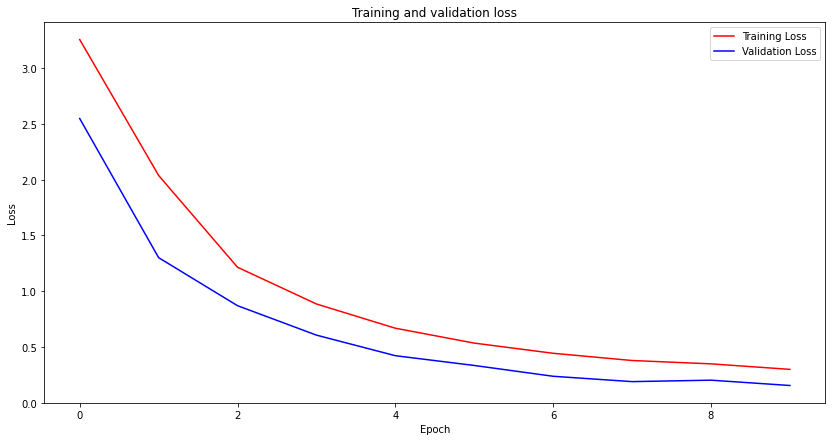

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 17s 61ms/step - loss: 0.1592 - accuracy: 0.9478
loss : 0.15924616158008575 acc : 0.9478281140327454


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 17s 60ms/step
              precision    recall  f1-score   support

           A       0.94      0.98      0.96       600
           B       0.84      0.99      0.91       600
           C       1.00      1.00      1.00       600
           D       0.99      0.99      0.99       600
           E       0.98      0.82      0.89       600
           F       1.00      0.98      0.99       600
           G       1.00      0.98      0.99       600
           H       0.99      1.00      0.99       600
           I       0.99      0.95      0.97       602
           J       0.99      0.99      0.99       600
           K       0.99      0.97      0.98       600
           L       0.99      0.99      0.99       600
           M       0.95      0.94      0.94       600
           N       0.98      0.95      0.97       602
           O       0.92      0.99      0.96       600
           P       0.92      0.99      0.96       600
           Q       0.99 

<Figure size 3600x3600 with 0 Axes>

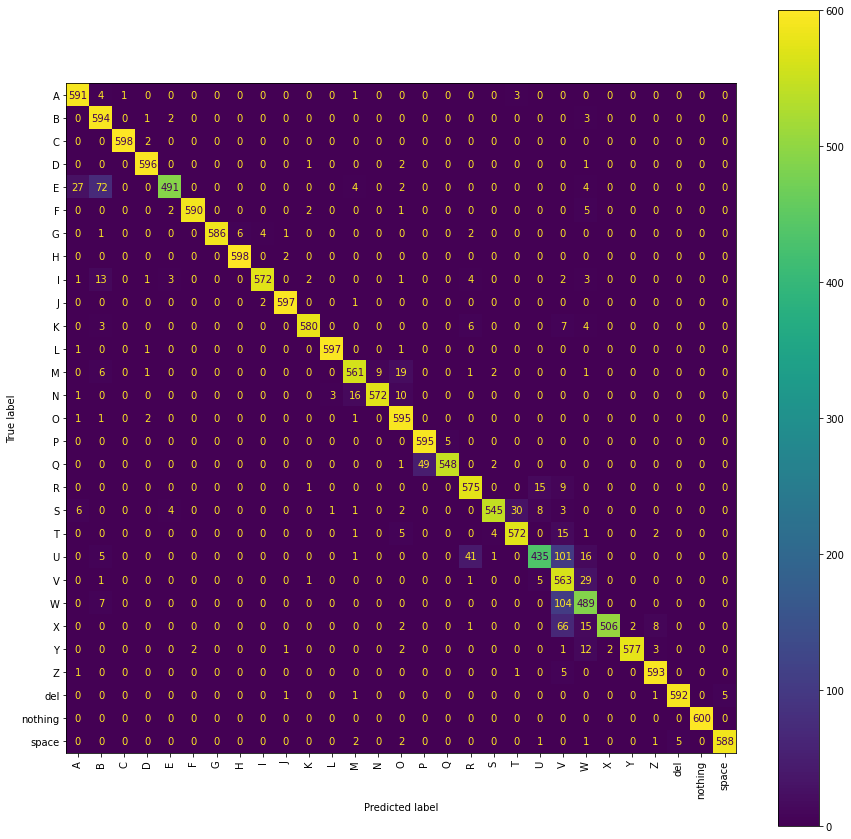

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_1l = Sequential()

model_5_1l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_1l.add(Activation('relu'))
model_5_1l.add(MaxPooling2D((2, 2)))
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Flatten())
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Dense(128, activation='relu'))

model_5_1l.add(Dense(num_classes, activation='softmax'))

model_5_1l.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 57, 57, 32)        6176      
                                                                 
 activation_5 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_11 (Dropout)        (None, 25088)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 77s 80ms/step - loss: 3.3948 - accuracy: 0.0205 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 76s 80ms/step - loss: 3.3161 - accuracy: 0.0535 - val_loss: 2.9254 - val_accuracy: 0.2228
Epoch 3/10
952/952 [==============================] - 76s 80ms/step - loss: 2.5545 - accuracy: 0.2787 - val_loss: 1.8072 - val_accuracy: 0.4699
Epoch 4/10
952/952 [==============================] - 76s 80ms/step - loss: 1.8565 - accuracy: 0.4415 - val_loss: 1.4252 - val_accuracy: 0.5943
Epoch 5/10
952/952 [==============================] - 76s 80ms/step - loss: 1.5326 - accuracy: 0.5260 - val_loss: 1.1485 - val_accuracy: 0.6550
Epoch 6/10
952/952 [==============================] - 76s 80ms/step - loss: 1.3458 - accuracy: 0.5785 - val_loss: 0.9454 - val_accuracy: 0.7217
Epoch 7/10
952/952 [==============================] - 76s 80ms/step - loss: 1.2025 - accuracy: 0.6182 - val_loss: 0.8272 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.394776,0.020504,3.367366,0.034475
1,3.316098,0.053534,2.925389,0.222822
2,2.554480,0.278655,1.807170,0.469892
3,1.856467,0.441491,1.425151,0.594346
4,1.532589,0.526020,1.148494,0.655022
5,1.345761,0.578488,0.945420,0.721673
6,1.202532,0.618232,0.827175,0.747070
7,1.068007,0.660078,0.631410,0.835670
8,0.944605,0.695292,0.563571,0.851184
9,0.838485,0.729061,0.501582,0.854516


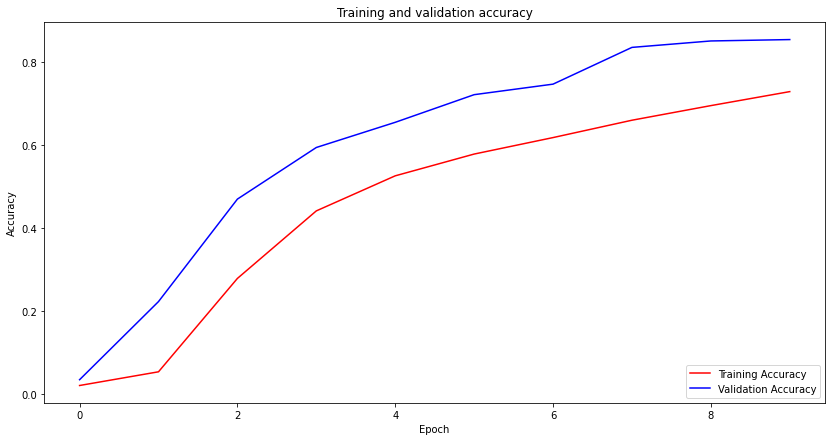

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_1l.history.history['accuracy']
val_acc= model_5_1l.history.history['val_accuracy']
loss= model_5_1l.history.history['loss']
val_loss= model_5_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

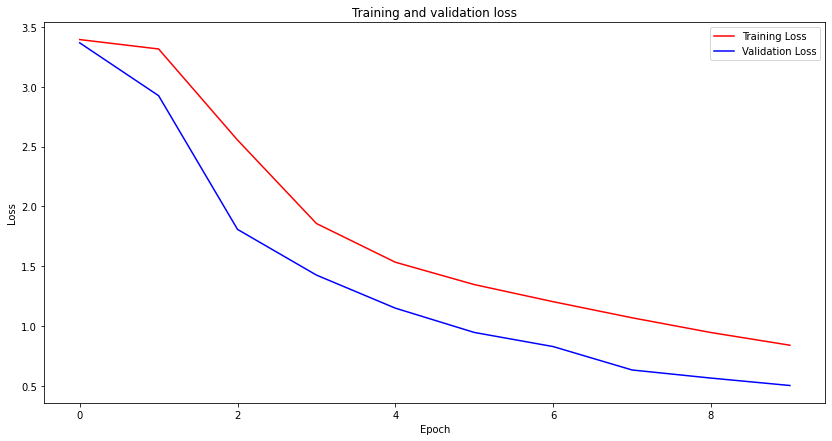

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 17s 61ms/step - loss: 0.5134 - accuracy: 0.8499
loss : 0.5134437680244446 acc : 0.8499195575714111


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 17s 62ms/step
              precision    recall  f1-score   support

           A       0.91      0.89      0.90       600
           B       0.66      0.98      0.79       600
           C       0.98      0.92      0.95       600
           D       0.83      0.94      0.88       600
           E       0.92      0.66      0.77       600
           F       0.91      0.99      0.95       600
           G       0.98      0.88      0.93       600
           H       0.87      1.00      0.93       600
           I       0.92      0.92      0.92       602
           J       0.95      0.96      0.95       600
           K       0.83      0.92      0.87       600
           L       0.98      0.92      0.95       600
           M       0.85      0.73      0.79       600
           N       0.86      0.91      0.88       602
           O       0.77      0.88      0.83       600
           P       0.69      0.97      0.81       600
           Q       0.94 

<Figure size 3600x3600 with 0 Axes>

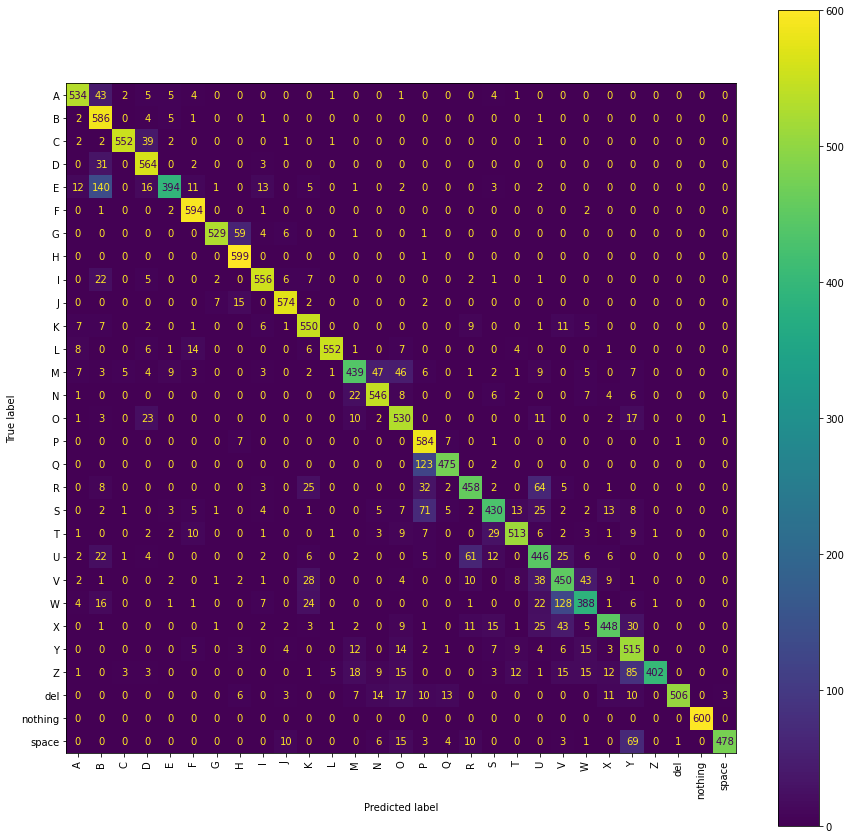

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

## **CNN Models with 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_2l = Sequential()

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Flatten())
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Dense(128, activation='relu'))

model_1_2l.add(Dense(num_classes, activation='softmax'))

model_1_2l.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 26, 26, 32)        0         
                                                        

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 95s 99ms/step - loss: 3.3784 - accuracy: 0.0292 - val_loss: 3.3604 - val_accuracy: 0.0410
Epoch 2/10
952/952 [==============================] - 89s 93ms/step - loss: 2.9709 - accuracy: 0.1496 - val_loss: 2.0889 - val_accuracy: 0.3901
Epoch 3/10
952/952 [==============================] - 91s 96ms/step - loss: 1.7875 - accuracy: 0.4580 - val_loss: 1.0948 - val_accuracy: 0.6850
Epoch 4/10
952/952 [==============================] - 91s 96ms/step - loss: 1.1551 - accuracy: 0.6298 - val_loss: 0.6269 - val_accuracy: 0.8480
Epoch 5/10
952/952 [==============================] - 88s 93ms/step - loss: 0.8468 - accuracy: 0.7229 - val_loss: 0.4451 - val_accuracy: 0.8719
Epoch 6/10
952/952 [==============================] - 89s 94ms/step - loss: 0.6633 - accuracy: 0.7796 - val_loss: 0.3278 - val_accuracy: 0.9145
Epoch 7/10
952/952 [==============================] - 89s 93ms/step - loss: 0.5485 - accuracy: 0.8167 - val_loss: 0.2683 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.378437,0.029238,3.360378,0.041025
1,2.970926,0.149604,2.088946,0.390140
2,1.787491,0.458006,1.094833,0.685015
3,1.155067,0.629806,0.626868,0.847966
4,0.846766,0.722855,0.445118,0.871869
5,0.663324,0.779607,0.327819,0.914502
6,0.548493,0.816725,0.268311,0.924155
7,0.469014,0.842056,0.194280,0.946104
8,0.421908,0.858604,0.157702,0.961043
9,0.383582,0.870145,0.142271,0.961848


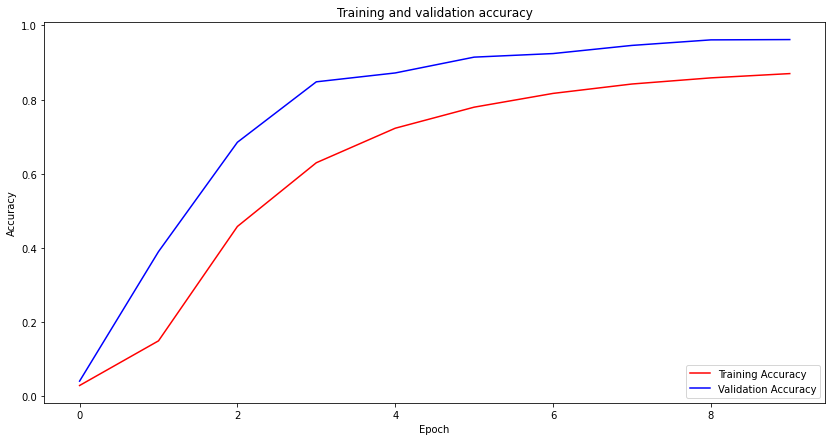

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_2l.history.history['accuracy']
val_acc= model_1_2l.history.history['val_accuracy']
loss= model_1_2l.history.history['loss']
val_loss= model_1_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

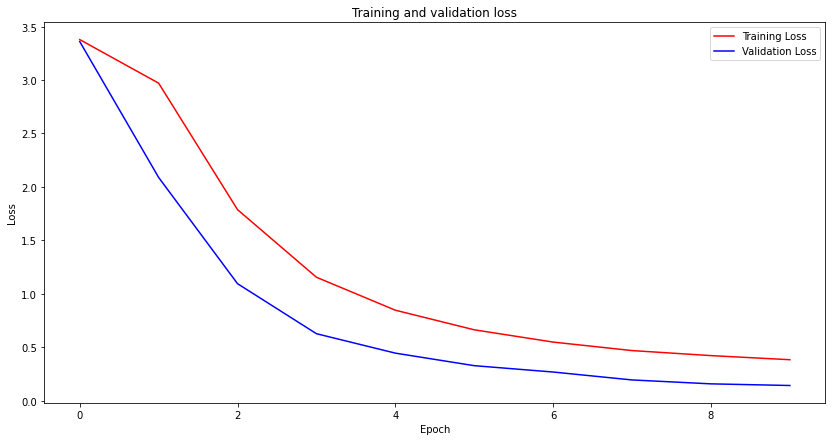

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.1435 - accuracy: 0.9579
loss : 0.14349320530891418 acc : 0.9578832387924194


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 67ms/step
              precision    recall  f1-score   support

           A       1.00      0.93      0.96       600
           B       0.99      0.94      0.96       600
           C       0.99      1.00      1.00       600
           D       0.99      0.99      0.99       600
           E       0.94      0.96      0.95       600
           F       1.00      1.00      1.00       600
           G       1.00      0.96      0.98       600
           H       0.97      0.99      0.98       600
           I       0.98      0.97      0.98       602
           J       0.99      1.00      0.99       600
           K       0.95      0.98      0.96       600
           L       1.00      1.00      1.00       600
           M       0.83      1.00      0.91       600
           N       1.00      0.86      0.92       602
           O       0.99      0.99      0.99       600
           P       0.96      1.00      0.98       600
           Q       1.00 

<Figure size 3600x3600 with 0 Axes>

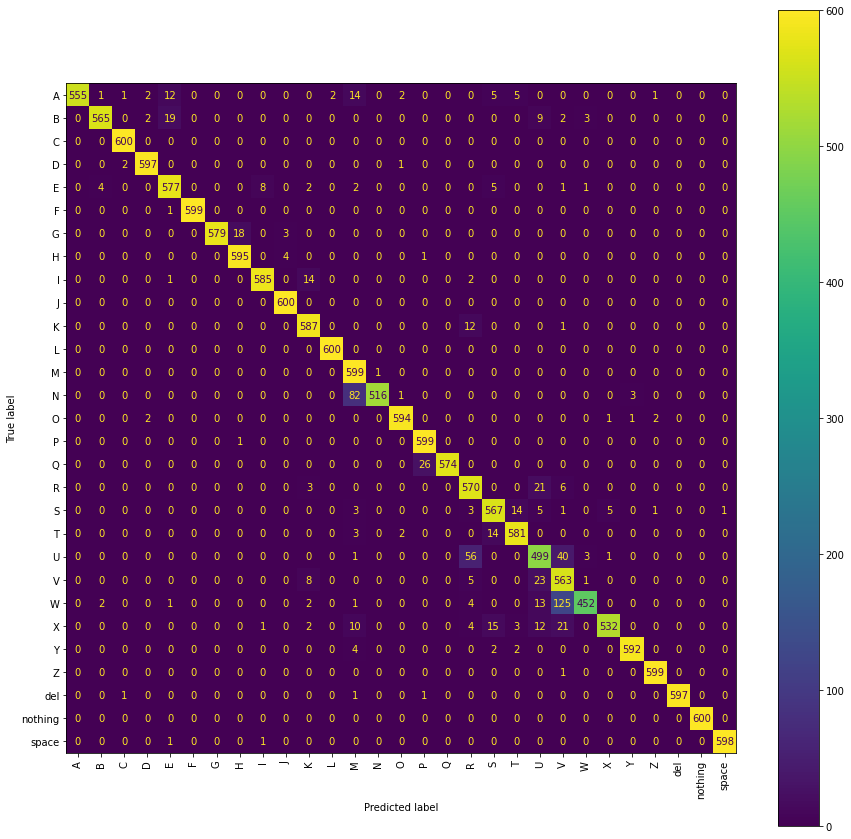

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_2l = Sequential()

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Flatten())
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Dense(128, activation='relu'))

model_2_2l.add(Dense(num_classes, activation='softmax'))

model_2_2l.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_2 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 32)        50208     
                                                                 
 activation_3 (Activation)   (None, 23, 23, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 91s 95ms/step - loss: 3.3708 - accuracy: 0.0319 - val_loss: 3.3193 - val_accuracy: 0.0380
Epoch 2/10
952/952 [==============================] - 92s 96ms/step - loss: 3.0849 - accuracy: 0.1181 - val_loss: 2.5083 - val_accuracy: 0.3140
Epoch 3/10
952/952 [==============================] - 91s 95ms/step - loss: 2.1502 - accuracy: 0.3676 - val_loss: 1.5252 - val_accuracy: 0.5549
Epoch 4/10
952/952 [==============================] - 91s 95ms/step - loss: 1.4551 - accuracy: 0.5458 - val_loss: 0.8926 - val_accuracy: 0.7653
Epoch 5/10
952/952 [==============================] - 96s 101ms/step - loss: 1.0955 - accuracy: 0.6428 - val_loss: 0.6817 - val_accuracy: 0.7967
Epoch 6/10
952/952 [==============================] - 92s 97ms/step - loss: 0.8909 - accuracy: 0.7094 - val_loss: 0.5818 - val_accuracy: 0.8206
Epoch 7/10
952/952 [==============================] - 97s 102ms/step - loss: 0.7667 - accuracy: 0.7466 - val_loss: 0.3930 - val_accurac

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.370775,0.031930,3.319332,0.038037
1,3.084931,0.118134,2.508337,0.313951
2,2.150171,0.367584,1.525197,0.554930
3,1.455132,0.545819,0.892568,0.765341
4,1.095470,0.642808,0.681689,0.796713
5,0.890922,0.709410,0.581785,0.820616
6,0.766705,0.746626,0.392997,0.891519
7,0.670197,0.775602,0.379354,0.886118
8,0.618927,0.792691,0.302730,0.909216
9,0.571842,0.809059,0.250430,0.940933


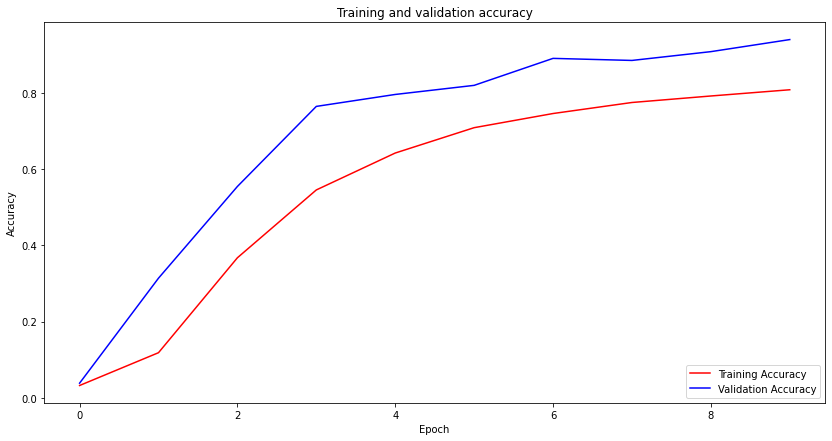

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_2l.history.history['accuracy']
val_acc= model_2_2l.history.history['val_accuracy']
loss= model_2_2l.history.history['loss']
val_loss= model_2_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

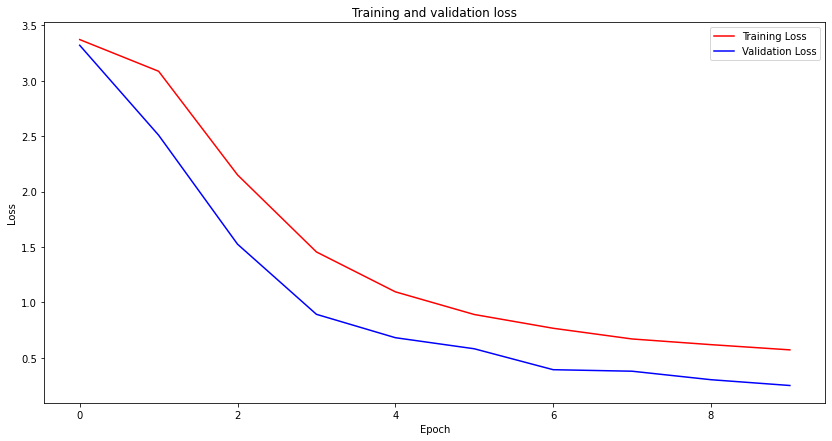

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 70ms/step - loss: 0.2513 - accuracy: 0.9378
loss : 0.25129252672195435 acc : 0.9377729296684265


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 69ms/step
              precision    recall  f1-score   support

           A       0.93      0.97      0.95       600
           B       0.97      0.96      0.96       600
           C       0.98      1.00      0.99       600
           D       0.99      0.97      0.98       600
           E       0.95      0.91      0.93       600
           F       1.00      0.99      0.99       600
           G       0.99      0.96      0.97       600
           H       0.98      0.98      0.98       600
           I       0.98      0.98      0.98       602
           J       0.99      0.99      0.99       600
           K       0.95      0.93      0.94       600
           L       0.94      1.00      0.97       600
           M       0.88      0.95      0.91       600
           N       1.00      0.82      0.90       602
           O       0.97      0.97      0.97       600
           P       0.96      0.99      0.98       600
           Q       0.98 

<Figure size 3600x3600 with 0 Axes>

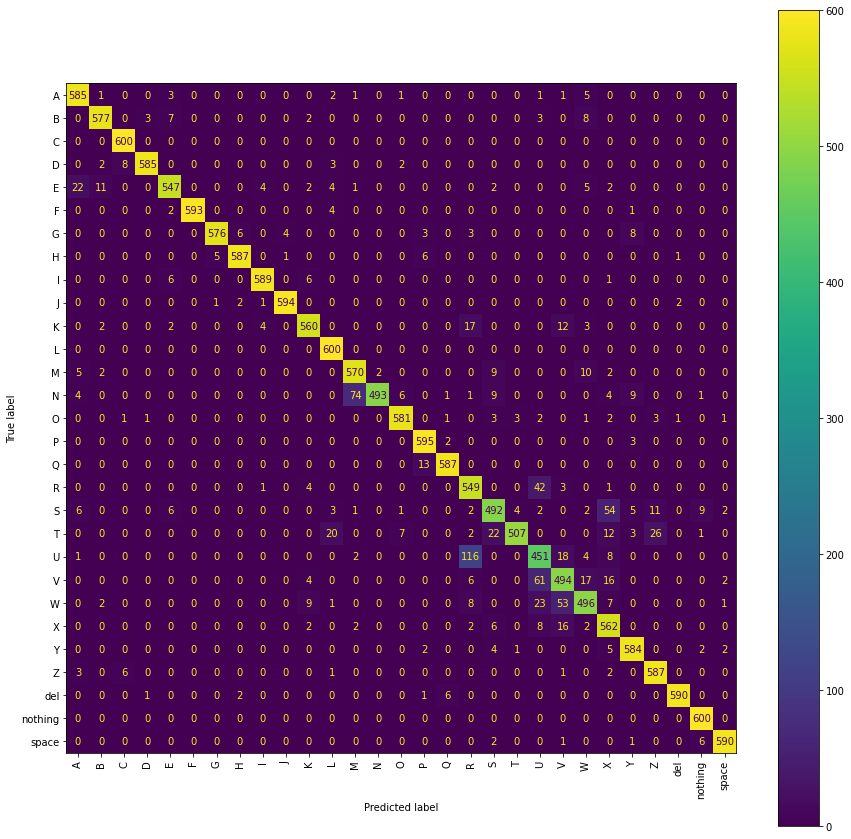

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_2l = Sequential()

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Flatten())
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Dense(128, activation='relu'))

model_3_2l.add(Dense(num_classes, activation='softmax'))

model_3_2l.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_4 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 32)        16416     
                                                                 
 activation_5 (Activation)   (None, 27, 27, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 90s 94ms/step - loss: 3.3849 - accuracy: 0.0295 - val_loss: 3.3593 - val_accuracy: 0.0427
Epoch 2/10
952/952 [==============================] - 85s 89ms/step - loss: 3.0183 - accuracy: 0.1451 - val_loss: 2.2208 - val_accuracy: 0.3734
Epoch 3/10
952/952 [==============================] - 86s 90ms/step - loss: 1.7986 - accuracy: 0.4469 - val_loss: 1.1320 - val_accuracy: 0.6682
Epoch 4/10
952/952 [==============================] - 87s 92ms/step - loss: 1.1704 - accuracy: 0.6253 - val_loss: 0.7945 - val_accuracy: 0.7667
Epoch 5/10
952/952 [==============================] - 84s 89ms/step - loss: 0.8801 - accuracy: 0.7120 - val_loss: 0.6306 - val_accuracy: 0.7996
Epoch 6/10
952/952 [==============================] - 86s 90ms/step - loss: 0.7075 - accuracy: 0.7674 - val_loss: 0.4580 - val_accuracy: 0.8677
Epoch 7/10
952/952 [==============================] - 86s 90ms/step - loss: 0.5945 - accuracy: 0.8027 - val_loss: 0.3467 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.384890,0.029484,3.359314,0.042749
1,3.018345,0.145057,2.220792,0.373362
2,1.798643,0.446892,1.131999,0.668237
3,1.170421,0.625308,0.794508,0.766720
4,0.880052,0.711971,0.630563,0.799586
5,0.707538,0.767377,0.458027,0.867732
6,0.594487,0.802689,0.346662,0.895311
7,0.508696,0.831434,0.311465,0.903126
8,0.453671,0.849723,0.233042,0.933004
9,0.408354,0.863332,0.187992,0.947943


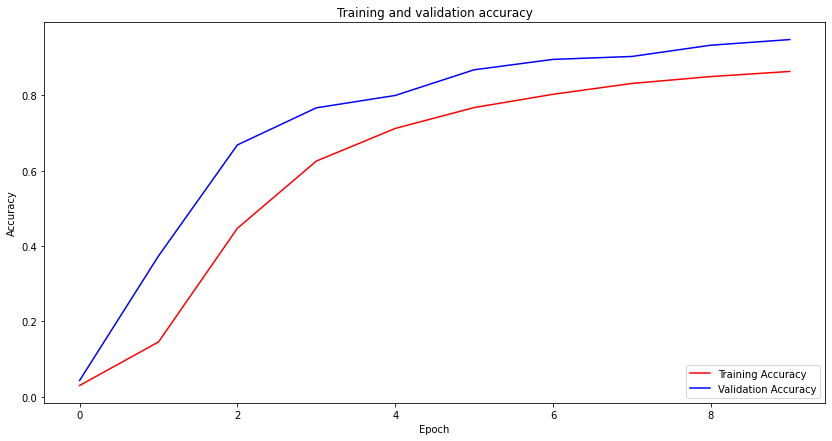

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_2l.history.history['accuracy']
val_acc= model_3_2l.history.history['val_accuracy']
loss= model_3_2l.history.history['loss']
val_loss= model_3_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

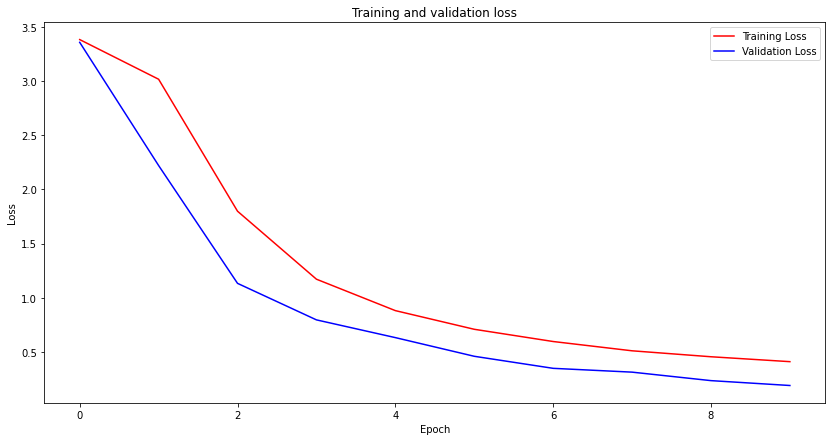

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 67ms/step - loss: 0.1841 - accuracy: 0.9512
loss : 0.18405207991600037 acc : 0.9511606693267822


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 67ms/step
              precision    recall  f1-score   support

           A       0.92      0.98      0.95       600
           B       0.99      0.86      0.92       600
           C       1.00      0.99      0.99       600
           D       0.96      1.00      0.98       600
           E       0.96      0.88      0.91       600
           F       0.99      0.99      0.99       600
           G       0.99      0.97      0.98       600
           H       0.97      1.00      0.98       600
           I       0.97      0.97      0.97       602
           J       0.99      1.00      1.00       600
           K       0.91      0.99      0.95       600
           L       1.00      1.00      1.00       600
           M       0.95      0.93      0.94       600
           N       0.90      0.96      0.93       602
           O       1.00      0.93      0.96       600
           P       1.00      0.99      0.99       600
           Q       0.99 

<Figure size 3600x3600 with 0 Axes>

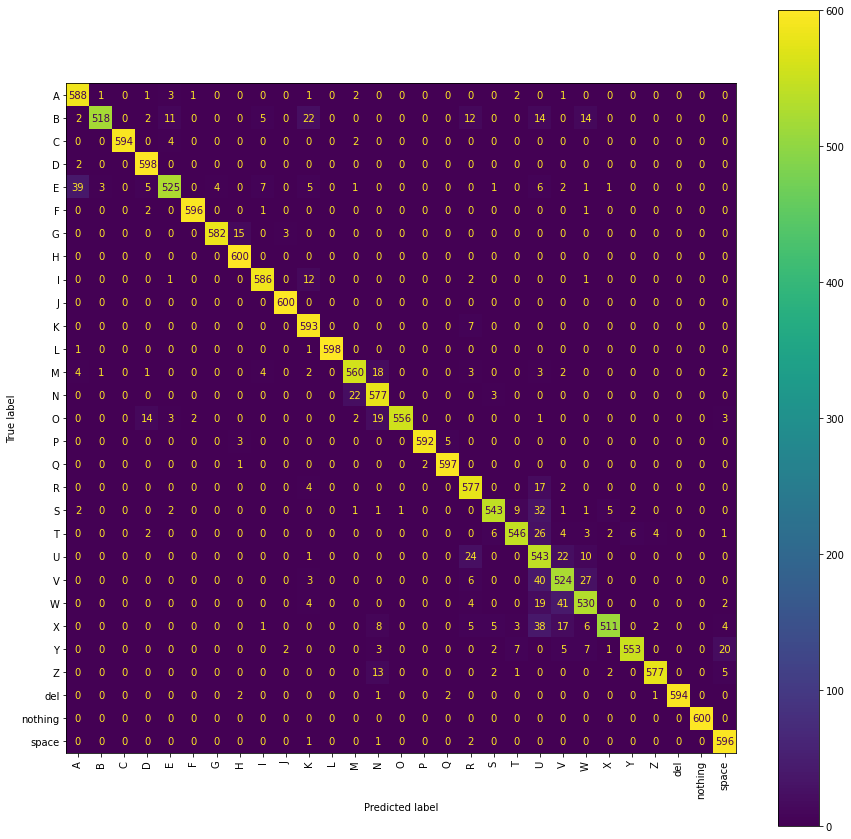

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_2l = Sequential()

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Flatten())
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Dense(128, activation='relu'))

model_4_2l.add(Dense(num_classes, activation='softmax'))

model_4_2l.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_6 (Activation)   (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        36896     
                                                                 
 activation_7 (Activation)   (None, 24, 24, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 90s 94ms/step - loss: 3.3831 - accuracy: 0.0298 - val_loss: 3.3676 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 89s 93ms/step - loss: 3.3733 - accuracy: 0.0245 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 95s 100ms/step - loss: 3.3724 - accuracy: 0.0200 - val_loss: 3.3686 - val_accuracy: 0.0349
Epoch 4/10
952/952 [==============================] - 93s 98ms/step - loss: 3.3734 - accuracy: 0.0291 - val_loss: 3.3661 - val_accuracy: 0.0337
Epoch 5/10
952/952 [==============================] - 93s 98ms/step - loss: 3.3487 - accuracy: 0.0441 - val_loss: 3.2198 - val_accuracy: 0.1010
Epoch 6/10
952/952 [==============================] - 97s 101ms/step - loss: 2.7907 - accuracy: 0.2034 - val_loss: 2.1099 - val_accuracy: 0.4321
Epoch 7/10
952/952 [==============================] - 89s 94ms/step - loss: 1.8394 - accuracy: 0.4385 - val_loss: 1.4386 - val_accurac

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.383079,0.029796,3.367631,0.034475
1,3.373294,0.024543,3.367505,0.034475
2,3.372407,0.019995,3.368618,0.034934
3,3.373405,0.029090,3.366091,0.033670
4,3.348701,0.044128,3.219826,0.101011
5,2.790717,0.203402,2.109897,0.432085
6,1.839435,0.438520,1.438640,0.603769
7,1.365022,0.571297,1.250695,0.657435
8,1.103782,0.649998,1.002072,0.728683
9,0.954197,0.694241,0.765297,0.804528


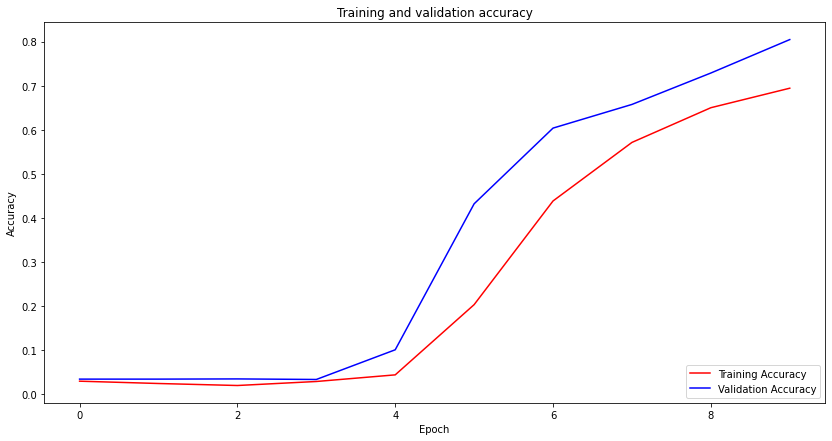

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_2l.history.history['accuracy']
val_acc= model_4_2l.history.history['val_accuracy']
loss= model_4_2l.history.history['loss']
val_loss= model_4_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

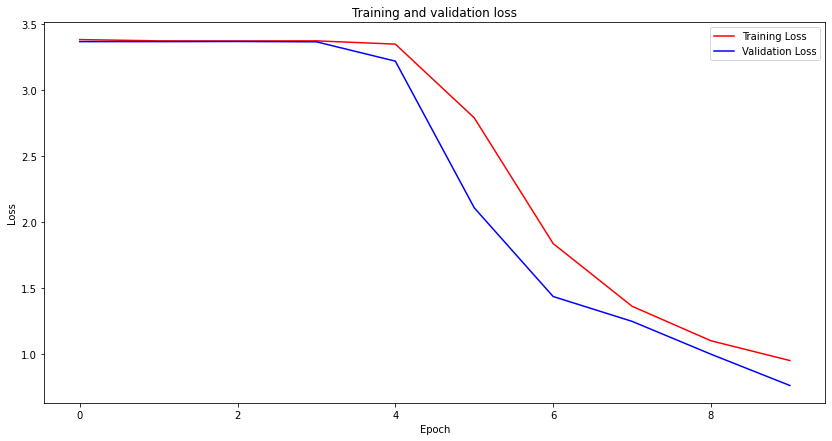

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.7629 - accuracy: 0.8099
loss : 0.7629057765007019 acc : 0.8099287748336792


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 68ms/step
              precision    recall  f1-score   support

           A       0.69      0.91      0.79       600
           B       0.88      0.84      0.86       600
           C       0.99      0.98      0.99       600
           D       0.97      0.86      0.91       600
           E       0.90      0.61      0.73       600
           F       0.98      0.91      0.95       600
           G       0.82      0.91      0.87       600
           H       0.97      0.81      0.88       600
           I       0.94      0.78      0.85       602
           J       0.96      0.94      0.95       600
           K       0.84      0.85      0.85       600
           L       0.99      0.82      0.90       600
           M       0.85      0.59      0.70       600
           N       0.90      0.82      0.86       602
           O       0.99      0.73      0.84       600
           P       0.91      0.82      0.87       600
           Q       0.79 

<Figure size 3600x3600 with 0 Axes>

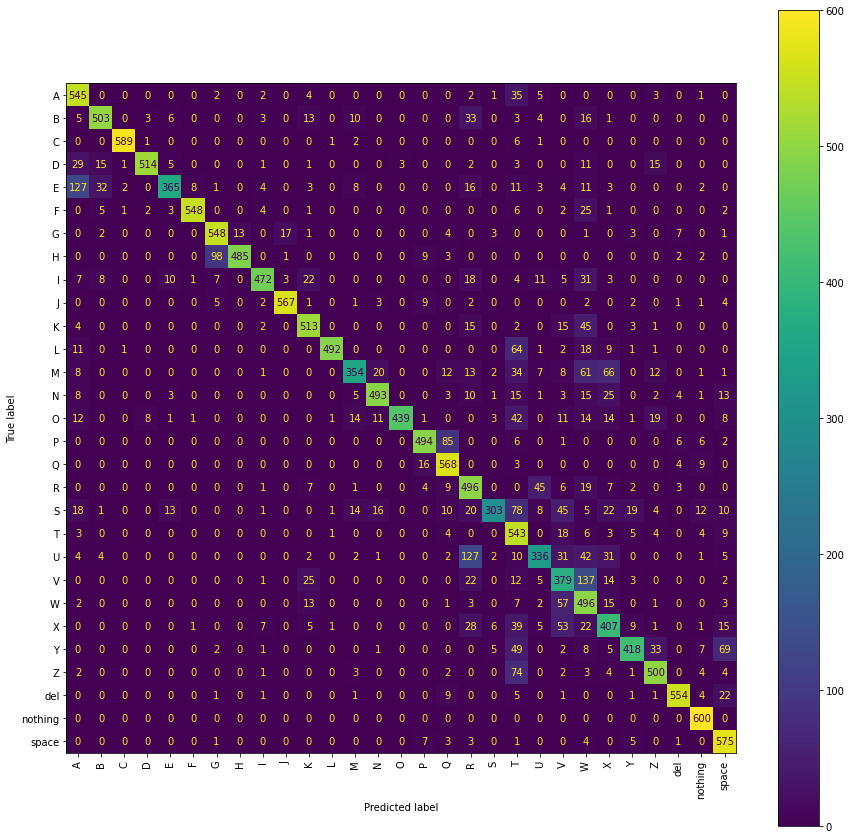

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_2l = Sequential()

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Flatten())
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Dense(128, activation='relu'))

model_5_2l.add(Dense(num_classes, activation='softmax'))

model_5_2l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 57, 57, 32)        6176      
                                                                 
 activation_8 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 32)        65568     
                                                                 
 activation_9 (Activation)   (None, 21, 21, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 95s 99ms/step - loss: 3.3748 - accuracy: 0.0314 - val_loss: 3.3349 - val_accuracy: 0.0449
Epoch 2/10
952/952 [==============================] - 99s 104ms/step - loss: 3.2063 - accuracy: 0.0809 - val_loss: 2.9994 - val_accuracy: 0.1659
Epoch 3/10
952/952 [==============================] - 93s 98ms/step - loss: 2.5642 - accuracy: 0.2586 - val_loss: 1.9462 - val_accuracy: 0.4416
Epoch 4/10
952/952 [==============================] - 99s 103ms/step - loss: 1.9450 - accuracy: 0.4168 - val_loss: 1.4183 - val_accuracy: 0.6182
Epoch 5/10
952/952 [==============================] - 107s 112ms/step - loss: 1.5508 - accuracy: 0.5187 - val_loss: 1.1402 - val_accuracy: 0.6792
Epoch 6/10
952/952 [==============================] - 103s 108ms/step - loss: 1.3093 - accuracy: 0.5857 - val_loss: 0.8546 - val_accuracy: 0.7766
Epoch 7/10
952/952 [==============================] - 108s 113ms/step - loss: 1.1253 - accuracy: 0.6407 - val_loss: 0.7595 - val_a

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.374781,0.031372,3.334912,0.044932
1,3.206282,0.080917,2.999411,0.165939
2,2.564176,0.258594,1.946179,0.441623
3,1.944999,0.416850,1.418306,0.618249
4,1.550831,0.518748,1.140177,0.679154
5,1.309280,0.585727,0.854572,0.776603
6,1.125333,0.640723,0.759474,0.774305
7,0.993443,0.680747,0.603132,0.835210
8,0.895894,0.708638,0.536005,0.860262
9,0.832079,0.729241,0.484294,0.876580


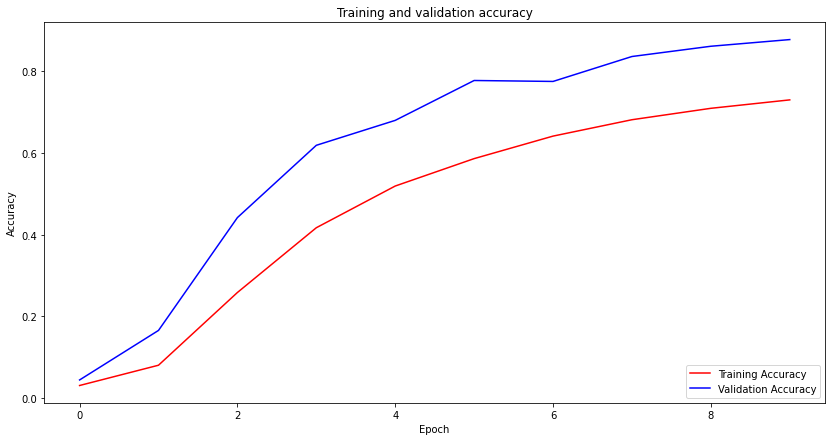

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_2l.history.history['accuracy']
val_acc= model_5_2l.history.history['val_accuracy']
loss= model_5_2l.history.history['loss']
val_loss= model_5_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

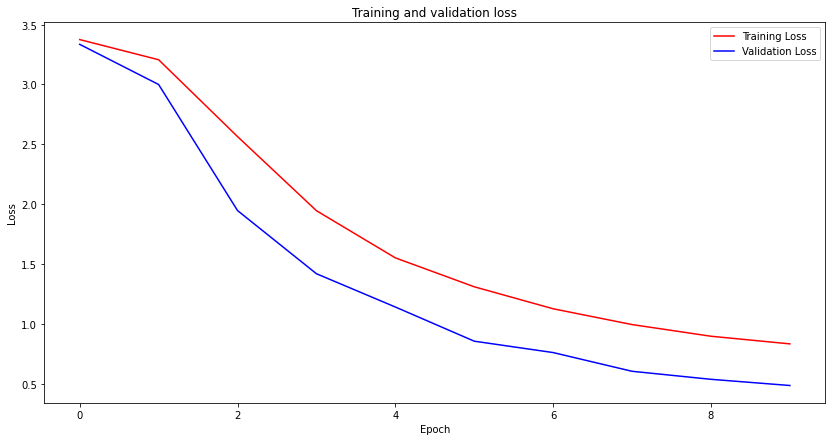

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.4782 - accuracy: 0.8824
loss : 0.47818854451179504 acc : 0.8823833465576172


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 69ms/step
              precision    recall  f1-score   support

           A       0.91      0.92      0.91       600
           B       0.92      0.91      0.92       600
           C       0.99      0.99      0.99       600
           D       0.95      0.94      0.95       600
           E       0.93      0.79      0.85       600
           F       0.99      0.97      0.98       600
           G       0.92      0.95      0.93       600
           H       0.99      0.93      0.95       600
           I       0.96      0.88      0.92       602
           J       0.91      0.98      0.94       600
           K       0.90      0.83      0.86       600
           L       0.99      0.96      0.98       600
           M       0.92      0.83      0.88       600
           N       0.93      0.83      0.88       602
           O       0.96      0.85      0.90       600
           P       0.99      0.87      0.93       600
           Q       0.91 

<Figure size 3600x3600 with 0 Axes>

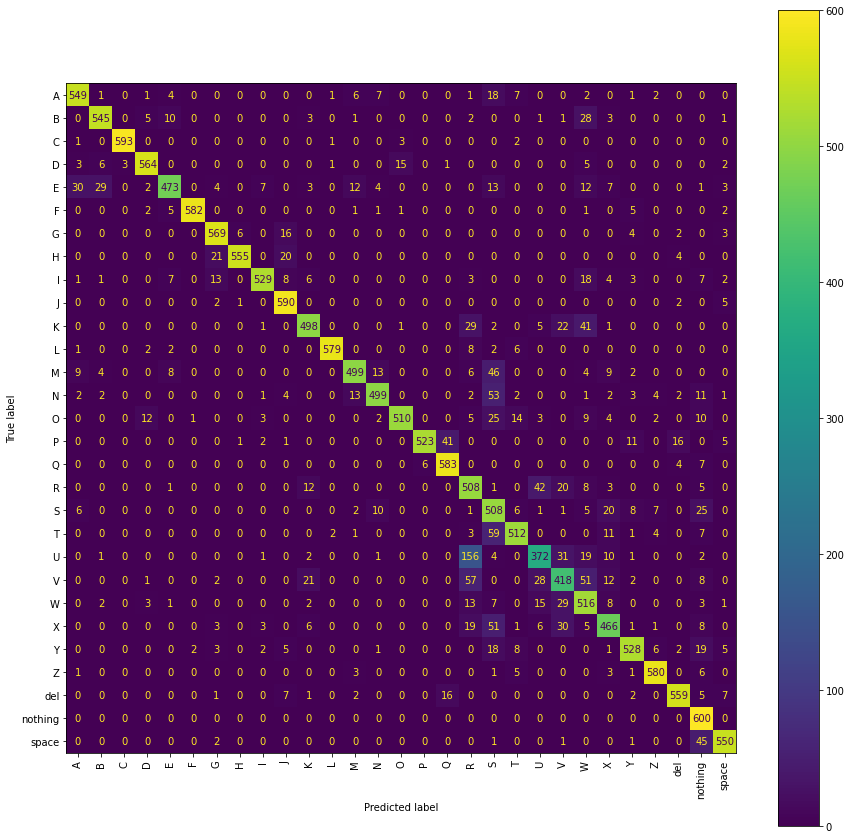

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

##**The references used for making all the 6 notebooks is given below**

▶ https://www.kaggle.com/yasinsoylu123/asl-recognition-keras-cnn

▶ https://www.kaggle.com/ryuodan/asl-detection-walkthrough

▶ https://www.kaggle.com/vishnu0399/asl-recognition-keras-cnn

▶ https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu

▶ https://www.kaggle.com/namanmanchanda/asl-detection-99-accuracy

▶ https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

▶ https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

▶ https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

▶ https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

▶ https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff

▶ https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

▶ https://www.analyticsvidhya.com/blog/2021/05/a-complete-hands-on-guide-to-train-your-neural-network-model-on-google-colab-gpu/

▶ https://medium.com/swlh/setting-up-google-colab-for-cnn-modeling-55b5208599c4

▶ https://colab.research.google.com/github/alx-xlx/gdrive-migration/blob/master/GoogleDrive_Migration.ipynb#scrollTo=jc99JEuRkUkG

▶ https://colab.research.google.com/github/shadab4150/Deep-Learning-Classifiers/blob/master/comparing_activation_function_ReLU_vs_Mish.ipynb

▶ https://github.com/digantamisra98/Mish

▶ https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/

▶ https://medium.com/tensorflow/introducing-tensorflow-addons-6131a50a3dcf

▶ https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/